In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Rain Prediction/rainfall_dataset.csv")
df = df.set_index('date_time')
df.index = pd.to_datetime(df.index)

In [ ]:
df.shape

(14608, 5)

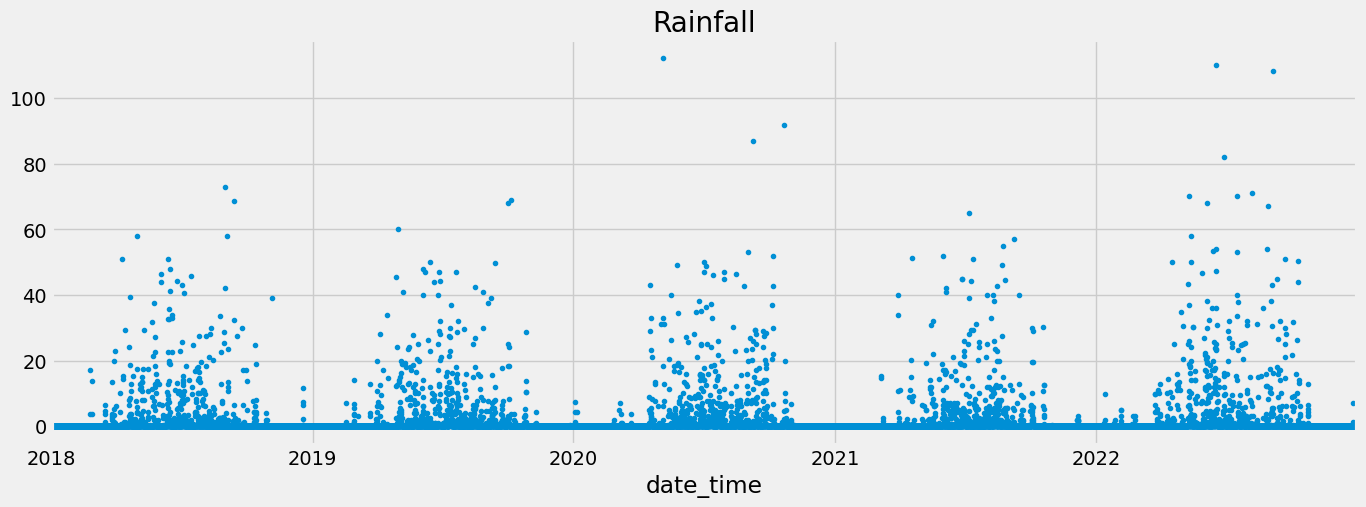

In [ ]:
df['rainfall'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Rainfall')
plt.show()

# Train / Test Split

In [ ]:
train = df.iloc[:11687]
test = df.iloc[11687:]

NameError: ignored

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train['rainfall'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['rainfall'].plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

NameError: ignored

#Feature Creation

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
df.columns

Index(['rainfall', 'relative_humidity', 'temperature', 'wind_speed_SP',
       'wind_speed_DR', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [ ]:
train = create_features(train)
test = create_features(test)

In [ ]:
FEATURES = ['relative_humidity', 'temperature', 'wind_speed_SP',
       'wind_speed_DR', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']

TARGET = 'rainfall'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[08:44:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.49275	validation_1-rmse:7.23995
[100]	validation_0-rmse:4.67581	validation_1-rmse:6.21606
[200]	validation_0-rmse:4.43036	validation_1-rmse:5.93505
[300]	validation_0-rmse:4.30830	validation_1-rmse:5.87696
[400]	validation_0-rmse:4.24053	validation_1-rmse:5.85970
[500]	validation_0-rmse:4.19253	validation_1-rmse:5.84005
[600]	validation_0-rmse:4.15770	validation_1-rmse:5.81535
[700]	validation_0-rmse:4.12946	validation_1-rmse:5.80320
[800]	validation_0-rmse:4.10291	validation_1-rmse:5.79687
[900]	validation_0-rmse:4.07996	validation_1-rmse:5.79024


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

# Feature Importance

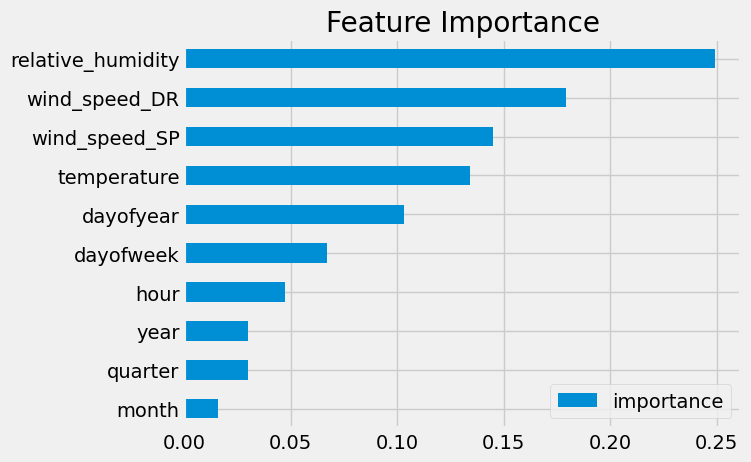

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

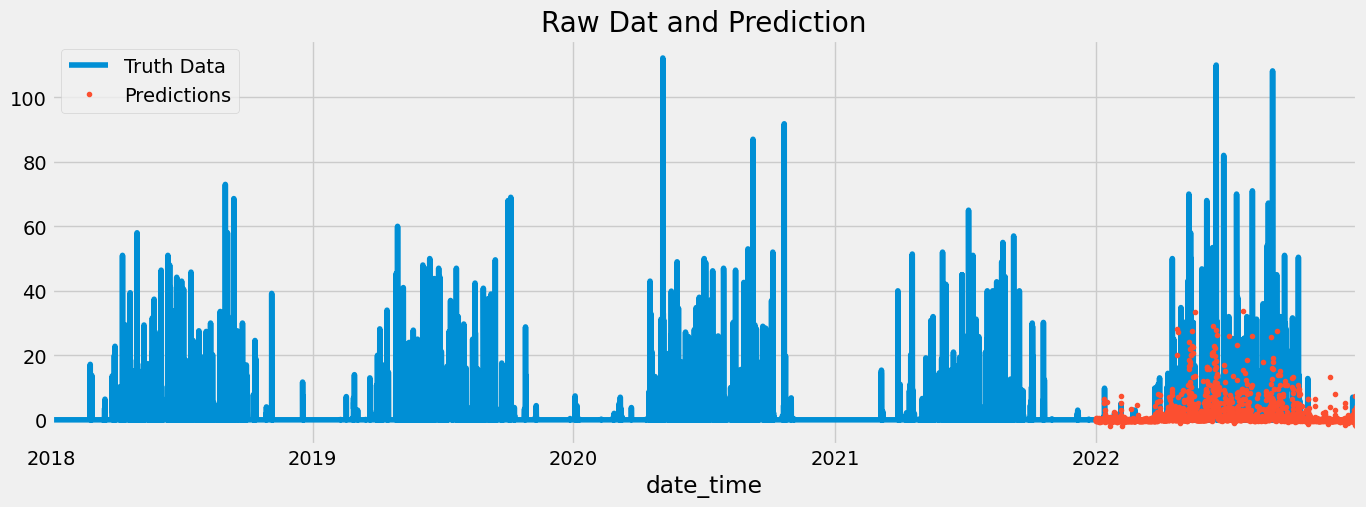

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['rainfall']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

# Score (RMSE)

In [ ]:
score = np.sqrt(mean_squared_error(test['rainfall'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 5.79


#Calculate Error
 - Look at the worst and best predicted days





In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-06-18    30.655132
2022-09-05    14.041961
2022-06-05    13.943711
2022-10-11    12.490804
2022-07-16    12.470570
2022-05-11    11.861596
2022-05-13    11.184660
2022-06-28    10.916675
2022-05-14     9.581013
2022-08-30     9.469133
Name: error, dtype: float64

In [ ]:
df

,rainfall,relative_humidity,temperature,wind_speed_SP,wind_speed_DR,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
date_time,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.0,98,16.5,2,8,0,0,1,1,2018,1,1,1,NaN
2018-01-01 03:00:00,0.0,74,19.2,3,9,3,0,1,1,2018,1,1,1,NaN
2018-01-01 06:00:00,0.0,57,25.7,3,12,6,0,1,1,2018,1,1,1,NaN
2018-01-01 09:00:00,0.0,58,26.2,4,13,9,0,1,1,2018,1,1,1,NaN
2018-01-01 12:00:00,0.0,77,23.0,0,0,12,0,1,1,2018,1,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 09:00:00,0.0,67,22.2,2,9,9,5,4,12,2022,365,31,52,-0.096787
2022-12-31 12:00:00,0.0,85,18.0,2,23,12,5,4,12,2022,365,31,52,0.507196
2022-12-31 15:00:00,0.0,93,15.8,3,19,15,5,4,12,2022,365,31,52,0.144006
